# Computational psychrometric analysis of HVAC system in sales room for big supermarket in peak hour of customers traffic rate

In my project the simulation model was created using Python programming language. HVAC system model was implemented using framework established by Christian Ghiaus (2014) based on psychrometric simulation model. The schematic representation of the simulation model's structure is explained in the figure below. This simulation model uses the computation of hourly steady-states, contingent upon the external weather data's ambient temperature 𝜃𝑜 and ambient relative humidity 𝜑𝑜. The inputs and parameters are explained below. An algorithm is employed to determine the necessary powers of cooling and heating to maintain the set point for sales room that is the thermal zone in my model. Secondly, the algorithm determines the latent heat that is present in the cooling- dehumidification module in the peak hour of customers load. Analisys of latent heat leads to determination of the maximum mass of water vapor that will be added to the air mass flow.

![Figure 1. HVAC System model](model_vis.png)

In [43]:
!pip install numpy pandas psychro 
!pip install matplotlib
import numpy as np
import pandas as pd
import psychro as psy


MxCcRhTzBl describes class of Mixing, Cooling, Reheating, Thermal Zone and Building composition.

In this section I need to define my parameters and inputs (('_init_'): Sets up the parameters and inputs: 

Where: 

        - m             mass flow rate of dry air, kg/s

        - mo            mass flow rate of outdoor dry air, kg/s
 
        - θo, φo        outdoor temperature & relative humidity, degr C, -

        - θ3, φ3        indoor temperature & relative humidity set points, degr C, -

        - mi            air infiltration mass flow rate, kg/s

        - Qsaux, Qlaux  auxiliary sensible and latent loads, kW
        
        - Qscab, Qlcab  cabinet's sensible and latent loads, kW

        - β             by-pass factor of cooling coil, -

        - UA            overall heat transfer coefficient of the building, W/K

Here displayed the system of equation used to create A matrix. Each row of the matrix A corresponds to a different process in the HVAC system. A[0,6] - here the 0 means the 0 equation, 6 is the numbering of unknown x, here it is θ4. 

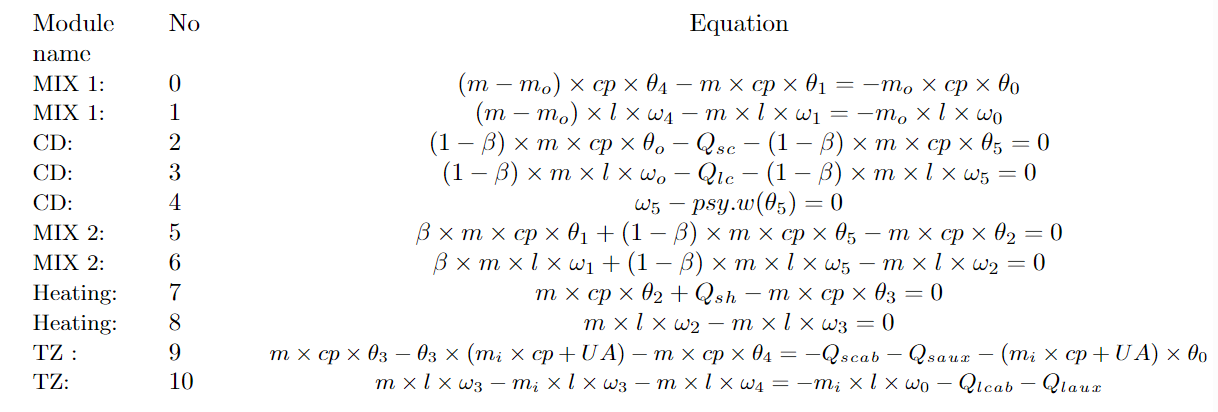

In [7]:
from IPython.display import Image, display

# Display an image file
image_path = "system_of_equations.png" 
display(Image(filename=image_path))

The method of lin_model solves a set of 13 linear equations, linearizing the saturation curve at a given temperature. 

The method solve_lin iteratively solves the linear model until the saturation point is found.

Then the mass flow rate optimization used the method m_ls: Finds the mass flow rate of dry air that meets the specified set point for sales room humidity.

Bypass factor optimization β_ls finds the bypass factor that meets the specified set point for supply air temperature or indoor humidity.

Here I implemented check point for saturation line: check_saturation ensures that no single point exceed the saturation curve on the psychronetric chart.

The module for Psychrometric chart displays and plotts the points and is represented by: psy_chart. Array A represents flows between my operating points.

The following command displays the heat outputs for sensible cooling, latent cooling and sensible heating. 


        Q = pd.Series(x[10:], index=['Qsc', 'Qlc', 'Qsh'])
        # Q.columns = ['kW']
        pd.options.display.float_format = '{:,.2f}'.format
        print()
        print(Q.to_frame().T / 1000, 'kW')
        return None

Moisture calculation, moisture_to_add should find the moisture needed to be added at point 5 to achieve the target humidity ratio. In this moment the following code doesn't fulfill my expectations according to analitical calculations of extracted water vapor from sales room. 

Here the inputs used in my simulation of winter case in January:

The following commands will display t array as set of temperatures, wv array as a set of humidity ratios.

The matrix A defines the connections between the points on a psychrometric chart. The matrix, along with the arrays t  and wv, is used to plot the HVAC processes on the psychrometric chart using the psy.chartA function.

The moisture mass flow rate to be added in the point 5 should be optimal according to psychrometric plot. The moisture_to_add method calculates the amount of moisture to be added based on the mass flow rate of dry air and the difference between the current and target humidity ratios at point 5. However, as mentioned before, according to analitical calculations, the output values are too low. 

Here I inserted the whole script to be launched in a compliant form :

In [44]:

import numpy as np
import pandas as pd
import psychro as psy


# constants
c = 1e3         # J/kg K, air specific heat
l = 2496e3      # J/kg, latent heat

# to be used in self.m_ls / least_squares
m_max = 100     # ks/s, max dry air mass flow rate
θs_0 = 5        # °C, initial guess for saturation temperature

class MxCcRhTzBl:
    """
    **HVAC composition**:
        mixing, cooling with dehumidification, heating, thermal zone of the building -sales room
        
    """

    def __init__(self, parameters, inputs):
        m, mo, β, Kθ, Kw = parameters
        θo, φo, θ3, w3, θIsp, φIsp, mi, UA, Qsaux, Qlaux, Qscab, Qlcab = inputs

        self.design = np.array([m, mo, β, Kθ, Kw,       # parameters
                                θo, φo, θ3, w3, θIsp, φIsp,     # inputs air out, in
                                mi, UA, Qsaux, Qlaux, 
                                Qscab, Qlcab])      # --"--  building
        self.actual = np.array([m, mo, β, Kθ, Kw,
                                θo, φo, θ3, w3, θIsp, φIsp,
                                mi, UA, Qsaux, Qlaux, 
                                Qscab, Qlcab])

    def lin_model(self, θs0):
        """
        Linearized model.
            Solves a set of 16 linear equations.
            Saturation curve is linearized in θs0.

        s-point (θs, ws):

        - is on a tangent to φ = 100 % in θs0;

        - is **not** on the saturation curve (Apparatus Dew Point ADP).


        Parameter from function call
        ----------------------------
        θs0     °C, temperature for which the saturation curve is liniarized

        Parameters from object
        ---------------------
        m, mo, θo, φo, θ3, w3, θIsp, φIsp, β, mi, UA, Qsaux, Qlaux, 
        Qscab, Qlcab, Kθ, Kw = self.actual

        Equations (13)
        -------------
        +-------------+-----+----+-----+----+----+----+----+----+
        | Element     | MX1 | CC/DEHUM | MIX2 | HC | TZ | Kθ | Kw |
        +=============+=====+====+=====+====+====+====+====+====+
        | N° equations|  2  |   3     |  2   |  2  | 2 | 1  |  1 |
        +-------------+-----+----+-----+----+----+----+----+----+

        Returns (13 unknowns)
        ---------------------
        x : θ1, w1, θ2, w2, θ3, w3, θ4, w4, θ5, w5,
            Qsc, Qlc, Qsh,
        """
        """
        <=4================================m==========================
               ||                                                   ||
               4 (m-mo) =======0=======                             ||
               ||       ||     β m   ||                             ||
       θo,φo=>[MX1]==0==||          [MX2]==2==[HC]=====3==>[TZ]==4==||
         mo             ||           ||        /   /       //       |
                        ===0=[CC]==1===       s   m       sl        |
                             /\\   (1-β)m     |           ||        |
                            t  sl             |          [BL]<-mi   |
                            |                 |          //         |
                            |                 |         sl          |
                            |                 |                     |
                            |                 |<------[K]-----------+<-wI
                            |<------------------------[K]-----------+<-θI
            """
       #List of parameters and inputs put into self.actual set
        m, mo, β, Kθ, Kw, θo, φo, θ3, w3, θIsp, φIsp, mi, UA, Qsaux, Qlaux, Qscab, Qlcab = self.actual
        wo = psy.w(θo, φo)      # hum. out
       #Set of 13 equations 
        A = np.zeros((13, 13))  # coefficents of unknowns
        b = np.zeros(13)        # vector of inputs
        #MIX
        A[0,6], A[0,0], b[0] = (m-mo) * c, -m * c, -mo * c * θo
        A[1,7], A[1,1], b[1] = (m-mo) * l, -m * l, -mo * l * wo
        #CC Dehumidification
        A[2,0], A[2,10], A[2,8], b[2] = (1 - β) * m * c, -1, -(1 - β) * m * c, 0
        A[3,1], A[3,11], A[3,9], b[3] = (1 - β) * m * l, -1, -(1 - β) * m * l, 0  
        A[4,9], A[4,8], b[4] = 1, -psy.wsp(θs0), psy.w(θs0, 1) - psy.wsp(θs0) * θs0
        #MIX2
        A[5,0], A[5,8], A[5,2], b[5] = β * m * c, (1 - β) * m * c, -m * c, 0
        A[6,1], A[6,9], A[6,3], b[6] = β * m * l, (1 - β) * m * l, -m * l, 0  
        #Heating
        A[7,2], A[7,12], A[7,4], b[7] = m * c, 1, -m * c, 0
        A[8,3], A[8,5], b[8] = m * l, -m * l, 0
        #TZ & Sales Room
        A[9,4], A[9,6], b[9] = m * c, -(m * c + mi * c + UA), -Qscab - Qsaux - (mi * c + UA) * θo
        A[10,5], A[10,7], b[10] = m * l, -(m * l + mi * l), -mi * l * wo - Qlcab - Qlaux
        # #Controller 
        A[11,4], A[11, 10], b[11] = Kθ, 1, Kθ * θIsp
        
        A[12,5], A[12, 11], b[12] = Kw, 1, Kw * psy.w(θIsp, φIsp)
        # Controllers chatGPT
        # A[11,4], A[11,12], b[11] = Kθ, -1, Kθ * θIsp
        # A[12,5], A[12,11], b[12] = Kw, -1, Kw * psy.w(θIsp, φIsp)
        x = np.linalg.solve(A, b)
        return x
    
        
    def solve_lin(self, θs0):
        """
        Finds saturation point on saturation curve ws = f(θs).
            Solves iterativelly *lin_model(θs0)*:
            θs -> θs0 until ws = psy(θs, 1).

        Parameters
        ----------
        θs0     initial guess saturation temperature

        Method from object
        ---------------------
        *self.lin_model(θs0)*

        Returns (13 unknowns)
        ---------------------
        x of *self.lin_model(self, θs0)*
        """
        #linearization of saturation points, we want to get 100% relative humidity at point 5
        Δ_ws = 10e-3  # kg/kg, initial difference to start the iterations
        while Δ_ws > 0.01e-3:
            x = self.lin_model(θs0)
            Δ_ws = abs(psy.w(x[8], 1) - x[9])   # psy.w(θs, 1) = ws
            θs0 = x[8]                          # actualize θs0 x[8] is theta 5
        return x

# mass flow rate optimization
    def m_ls(self, value, sp):
        """
        Mass flow rate m controls supply temperature θS or indoor humidity wI.
            Finds m which solves value = sp, i.e. minimizes ε = value - sp.
            Uses *scipy.optimize.least_squares* to solve the non-linear system.

        Parameters
        ----------
        value   string: 'θS' od 'wI' type of controlled variable
        sp      float: value of setpoint
#decimal numbers for set point eg. 21.65
        Calls
        -----
        *ε(m)*  gives (value - sp) to be minimized for m
#calculates the residuals between the observed data and the values predicted by the model
        Returns (13 unknowns)
        ---------------------
        x           given by *self.lin_model(self, θs0)*
        
        """
#least_squares function will try to find the parameters that minimize the sum of the squares of these residual                    
        from scipy.optimize import least_squares

        def ε(m):
            """
            Gives difference ε = (values - sp) function of m
                ε  calculated by self.solve_lin(ts0)
                m   bounds=(0, m_max); m_max hard coded (global variable)

            Parameters
            ----------
            m : mass flow rate of dry air

            From object
                Method: self.solve.lin(θs0)
                Variables: self.actual <- m (used in self.solve.lin)
            Returns
            -------
            ε = value - sp: difference between value and its set point
            """
            #Set point to point 3 
            self.actual[0] = m  #the 0 parameter from self.actual is m
            x = self.solve_lin(θs_0)
            if value == 'θS':
                θS = x[4]       # supply air
                return abs(sp - θS)
            elif value == 'φI':
                wI = x[5]       # indoor air
                return abs(sp - wI)
            else:
                print('ERROR in ε(m): value not in {"θS", "wI"}')

        m0 = self.actual[0]     # initial guess m0 = m
        if value == 'φI':
            self.actual[4] = 0  #humidity to 0 
            sp = psy.w(self.actual[7], sp) #function of set point theta 3
        # gives m for min(θSsp - θS); θs_0 is the initial guess of θs
        res = least_squares(ε, m0, bounds=(0, m_max)) #solves nonlinear least-squares problem

        if res.cost < 0.1e-3: #cost of solution, is it good enaugh
            m = float(res.x)  #if solution is good enaugh m is assigned
            # print(f'm = {m: 5.3f} kg/s')
        else:
            print('RecAirVAV: No solution for m') #if solution doesn't fulfill quality of calculation accuracy

        self.actual[0] = m

        x = self.solve_lin(θs_0)
        return x

    def β_ls(self, value, sp):
        """
        Bypass β controls supply temperature θS or indoor humidity wI.
            Finds β which solves value = sp, i.e. minimizes ε = value - sp.
            Uses *scipy.optimize.least_squares* to solve the non-linear system.

        Parameters
        ----------
        value   string: 'θS' od 'wI' type of controlled variable
        sp      float: value of setpoint

        Calls
        -----
        *ε(m)*  gives (value - sp) to be minimized for m

        Returns (13 unknowns)
        ---------------------
        x           given by *self.lin_model(self, θs0)*
        """
        from scipy.optimize import least_squares

        def ε(β):
            """
            Gives difference ε = (values - sp) function of β
                ε  calculated by self.solve_lin(ts0)
                β   bounds=(0, 1)

            Parameters
            ----------
            β : by-pass factor of the cooling coil

            From object
                Method: self.solve.lin(θs0)
                Variables: self.actual <- m (used in self.solve.lin)
            Returns
            -------
            ε = value - sp: difference between value and its set point
            """
            self.actual[2] = β
            x = self.solve_lin(θs_0)
            if value == 'θS':
                θS = x[4]       # supply air
                return abs(sp - θS)
            elif value == 'φI':
                wI = x[5]       # indoor air
                return abs(sp - wI)
            else:
                print('ERROR in ε(β): value not in {"θS", "wI"}')

        β0 = self.actual[2]     # initial guess
        β0 = 0.1
        if value == 'φI':
            self.actual[4] = 0
            sp = psy.w(self.actual[7], sp)
        # gives m for min(θSsp - θS); θs_0 is the initial guess of θs
        res = least_squares(ε, β0, bounds=(0, 1))

        if res.cost < 1e-5:
            β = float(res.x)
            # print(f'm = {m: 5.3f} kg/s')
        else:
            print('RecAirVBP: No solution for β')

        self.actual[2] = β
        x = self.solve_lin(θs_0)
        return x

    def check_saturation(self, x):
        for i in range(0, 10, 2):  # check θ1, θ2, θ3, θ4, θ5
            θ = x[i]
            w = x[i + 1]
            if w > psy.w(θ, 1):
                print(f"Point {i//2} is beyond saturation curve. Adjusting...")
                x[i + 1] = psy.w(θ, 1)
        return x
    
    def psy_chart(self, x, θo, φo):
        """
        Plot results on psychrometric chart.

        Parameters
        ----------
        x : θ1, w1, θ2, w2, θ3, w3, θ4, w4, θ5, w5,
            Qsc, Qlc, Qsh
                    results of self.solve_lin or self.m_ls
        θo, φo      outdoor point

        Returns
        -------
        None.

        """
        # Processes on psychrometric chart 
        wo = psy.w(θo, φo)
        # Points: O, s, S, I
        θ = np.append(θo, x[0:10:2])
        w = np.append(wo, x[1:10:2])
        # Points       0   1  2  3  4  5       Elements
        A = np.array([[-1, 1, 0, 0, 0, 1],      # MR
                      [0, -1, 1, 0, 0, 0],      # CC
                      [0, 0, -1, 1, -1, 0],     # MX
                      [0, 0, 0, -1, 1, 0],      # HC
                      [0, 0, 0, 0, -1, 1]])     # TZ
        psy.chartA(θ, w, A)

        θ = pd.Series(θ)
        w = 1000 * pd.Series(w)         # kg/kg -> g/kg
        P = pd.concat([θ, w], axis=1)   # points
        P.columns = ['θ [°C]', 'w [g/kg]']

        output = P.to_string(formatters={
            'θ [°C]': '{:,.2f}'.format,
            'w [g/kg]': '{:,.2f}'.format})
        print()
        print(output)

        Q = pd.Series(x[10:], index=['Qsc', 'Qlc', 'Qsh'])
        # Q.columns = ['kW']
        pd.options.display.float_format = '{:,.2f}'.format
        print()
        print(Q.to_frame().T / 1000, 'kW')
        return None
# Constant air volume (CAV) 
    def CAV_wd(self, θo=-3.7, φo=0.7, θIsp=24, φIsp=0.55,
                mi=0.127, UA=675, Qsaux=6.124, Qlaux=7.44 , Qscab=-60.509, Qlcab=-39.537):
#    def CAV_wd(self, θo=0.9, φo=0.80, θIsp=19, φIsp=0.5,
#                mi=1.35, UA=675, Qsaux=-14.7917363 * 1000, Qlaux=3.36 * 1000, Qscab=4.253246499 * 1000, Qlcab=2.148192063 * 1000):



        """
        Constant air volume (CAV) to be used in Jupyter with widgets

        Parameters: given in Jupyetr widget
        ----------

        Returns
        -------
        None.
        """
        # To use fewer variables in Jupyter widget:
        # select what to be updated in self.actual, e.g.:
        # self.actual[[0, 1, 2, 5, 6]] = m, θo, φo, 1000 * QsTZ, 1000 * QlTZ
        self.actual[5:] = np.array([θo, φo, θIsp, φIsp,
                                mi, UA, Qsaux, Qlaux, Qscab, Qlcab])
        # self.actual[5:] = θo, φo, θIsp, φIsp, mi, UA, Qsa, Qla

        θ0 = 40
        x = self.solve_lin(θ0)
        # print(f'm = {self.actual[0]: .3f} kg/s,\
        #       mo = {self.actual[1]: .3f} kg/s')
        print('m = {m: .3f} kg/s, mo = {mo: .3f} kg/s'.format(
            m=self.actual[0], mo=self.actual[1]))
        self.psy_chart(x, self.actual[5], self.actual[6])
    def moisture_to_add(self, θ5, w5, w5_target):
        """
        Calculate the moisture to be added to the air at point 5.

        Parameters
        ----------
        θ5 : float
            Temperature at point 5 (°C).
        w5 : float
            Current humidity ratio at point 5 (kg/kg).
        w5_target : float
            Target humidity ratio at point 5 (kg/kg).

        Returns
        -------
        moisture_add : float
            Moisture to be added (kg/s).
        """
        m = self.actual[0]  # mass flow rate of dry air (kg/s)
        moisture_add = m * (w5_target - w5)
        return moisture_add

θo = -3.8
φo = 0.7
θ3 = 24.0
w3 = psy.w(θ3, 0.55)
φIsp = 0.55
θIsp = 24.0
mi = 0.127
UA = 675
Qsaux = 6.124   #kW
Qlaux = 7.44    #kW
Qscab = -60.509 #kW
Qlcab = -39.537 #kW
m = 1.601  #initially 1 kg/s
mo = m * 0.1
β = 0.7        #initial 0.7
Kθ = 1e9
Kw = 1e9

inputs = θo, φo, θ3, w3, θIsp, φIsp, mi, UA, Qsaux, Qlaux, Qscab, Qlcab
parameters = m, mo, β, Kθ, Kw
model = MxCcRhTzBl(parameters, inputs)
x = model.solve_lin(θIsp)
t = np.array([θo, x[0], x[2], x[4], x[6], x[8]])
wv = np.array([psy.w(θo, φo), x[1], x[3], x[5], x[7], x[9]])
A = np.zeros([5, len(t)])
A[0, 0], A[0, 1], A[0, 4] = 1, -1, 1
A[1, 1], A[1, 5] = 1, -1
A[2, 1], A[2, 5], A[2, 2] = 1, 1, -1
A[3, 2], A[3, 3] = 1, -1
A[4, 3], A[4, 4] = 1, -1
psy.chartA(t, wv, A)


# Calculate the moisture to be added at point 5
w5_target = psy.w(θIsp, φIsp)
moisture_add = model.moisture_to_add(x[8], x[9], w5_target)
print(f"Moisture to be added at point 5: {moisture_add:.4f} kg/s")

AttributeError: module 'psychro' has no attribute 'w'

To display the values of x[] in a Jupyter Notebook, please simply type the variable name in a code cell and run it.